###### 本案例源于kaggle，数据是titan数据，主要目的是为了学习stacking
kaggle网址为：https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python  
竞赛地址为：https://www.kaggle.com/c/titanic/data  
###### 后面用到的变量的解释说明

Variable	| Definition	| Key
----| ---- | ----
survival	| Survival	| 0 = No, 1 = Yes
pclass	| Ticket class	| 1 = 1st, 2 = 2nd, 3 = 3rd
sex	| Sex	
Age	| Age in years	
sibsp	| # of siblings / spouses aboard the Titanic	
parch	| # of parents / children aboard the Titanic	
ticket	| Ticket number	
fare	| Passenger fare	
cabin	| Cabin number	
embarked	| Port of Embarkation	| C = Cherbourg, Q = Queenstown, S = Southampton

In [1]:
import pandas as  pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline    
# 魔法函数

# import plotly.offline as py    # 交互图库
# py.init_notebook_mode(connected=True)
# import plotly.graph_objs as go
# import plotly.tools as tl

import warnings
warnings.filterwarnings('ignore')

# 用以下5个基本模型进行stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier)
# ExtraTreesClassifier与随机森林相似，ET的每颗决策树会使用全部的数据集，并且划分点也是完全随机的，
# 而RF是先采样，再根据信息增益来选择最优特征来进行划分
from sklearn.svm import SVC
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score
from mlxtend.classifier import StackingClassifier

###### Feature Exploration, Engineering and Cleaning

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
# 存储乘客ID
PassengerId = test['PassengerId']
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
print('变量类型：\n', train.dtypes)
print()
print('训练集的缺失值情况：\n',train.isnull().sum())
print()
print('测试集的缺失值情况：\n',test.isnull().sum())
print('train的describe: \n',train.describe())

变量类型：
 PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

训练集的缺失值情况：
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

测试集的缺失值情况：
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
train的describe: 
        PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118  

可以看出，age\cabin\embarked\fare存在着不同程度的缺失值，接下来通过查看其各自的分布来处理缺失值。  
age和fare是float64类型，考虑做直方图或密度图查看其分布；cabin和embarked是object类型，考虑做堆叠图来查看其对survived的影响。

###### 1.1 查看缺失数据分布以考虑用什么进行填充缺失值

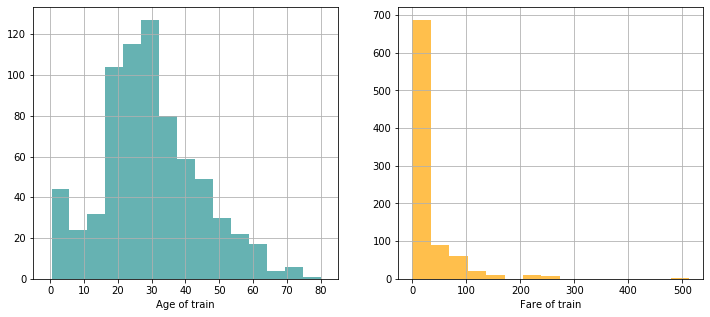

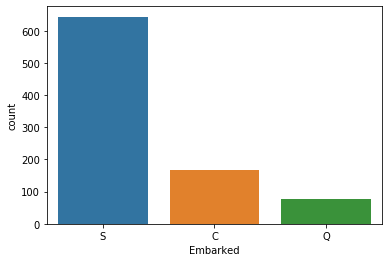

Cabin的缺失值有687个，占比为77.10437710437711%
Cabin不同类型的种类有: 147


In [4]:
train_1 = train.copy()
test_1 = test.copy()
# 1、先查看age的直方图
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
ax = train_1['Age'].hist(bins=15, color='teal', alpha=0.6)
ax.set(xlabel='Age of train')
plt.xlim([-5,85])
## Age的中位数为28，均值为29.7，再结合直方图，考虑用均值进行缺失值填充 ##

# 2、查看fare的分布
plt.subplot(1,2,2)
ax = train_1['Fare'].hist(bins=15, color='orange', alpha=0.7)
ax.set(xlabel='Fare of train')
plt.show()
## Fare的均值为32.20，中位数为14.45，再结合直方图，考虑用中位数进行缺失值填充 ##

# 3、对Embarked绘制条形图或堆叠图
sns.countplot(x='Embarked', data=train_1)
plt.show()
## 可以看出S( S = Southampton)登船的最多，所以缺失值用S进行填充 ##

# 4、对Cabin进行分析
print('Cabin的缺失值有{}个，占比为{}%'.format(train_1['Cabin'].isnull().sum(), train_1['Cabin'].isnull().sum()/train_1.shape[0]*100))
print('Cabin不同类型的种类有:', len(train_1['Cabin'].value_counts()))    
## 缺失值较多，且不同类型较多，无法进行填充，所以决定将其舍弃 ##

###### 1.2 缺失值处理

In [5]:
# Age
train_1['Age'].fillna(train['Age'].mean(skipna=True), inplace=True)
test_1['Age'].fillna(train['Age'].mean(skipna=True), inplace=True)
# Fare: 只有test存在缺失值
test_1['Fare'].fillna(train['Fare'].median(skipna=True), inplace=True)
# Embarked: 只有train存在缺失值
train_1['Embarked'].fillna('S', inplace=True)
print(train_1['Embarked'].value_counts())
# Cabin: 直接删掉
train_1.drop(['Cabin'], axis=1, inplace=True)
test_1.drop(['Cabin'], axis=1, inplace=True)

train_1.head(3)

S    646
C    168
Q     77
Name: Embarked, dtype: int64


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S


###### 2 特征工程之特征构造
初步构造两个特征：IsAlone/NameTitle

In [6]:
# 1、先构造IsAlone
train_1['IsAlone'] = np.where(train_1['SibSp']+train_1['Parch']>0, 0, 1)
test_1['IsAlone'] = np.where(test_1['SibSp']+test_1['Parch']>0, 0, 1)

# 2、构造NameTitle：表示Name里面的头衔Mr, Mrs等
def GetNameTitle(name):
    rst = re.compile('.*?, (.*?). .*?').findall(name)
    if len(rst)==0:
        return ''
    return rst[0]
train_1['NameTitle'] = train_1['Name'].apply(GetNameTitle)
test_1['NameTitle'] = test_1['Name'].apply(GetNameTitle)


###### 3 建模前最后的数据清洗

In [7]:
print(train_1.head(3))
# 最后进行删除，以便删除全部不需要的列
train_1['Sex'] = train_1['Sex'].map({'male':1, 'female':0}).apply(int)
test_1['Sex'] = test_1['Sex'].map({'male':1, 'female':0}).apply(int)

train_1['Embarked'] = train_1['Embarked'].map({'C':1, 'Q':2, 'S':3}).apply(int)
test_1['Embarked'] = test_1['Embarked'].map({'C':1, 'Q':2, 'S':3}).apply(int)

dict_NameTitle = {'Mr':1, 'Miss':2, 'Mrs':3, 'Master':4, 
                  'Mlle': 2, 'Ms':2,
                  'Mme':3,
                  'Dr':5, 'Rev':5, 'Col':5, 'Major':5, 'Capt':5, 'Don':5, 'th':5, 'Lady':5, 'Sir':5, 
                  'Jonkheer':5, 'Dona':5
                 }
train_1['NameTitle'] = train_1['NameTitle'].map(dict_NameTitle).apply(int)
test_1['NameTitle'] = test_1['NameTitle'].map(dict_NameTitle).apply(int)


drop_lst = ['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket']
train_1.drop(drop_lst, axis=1, inplace=True)
test_1.drop(drop_lst, axis=1, inplace=True)

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   

   Parch            Ticket     Fare Embarked  IsAlone NameTitle  
0      0         A/5 21171   7.2500        S        0        Mr  
1      0          PC 17599  71.2833        C        0       Mrs  
2      0  STON/O2. 3101282   7.9250        S        1      Miss  


###### 4 查看不同特征对Survived的影响(低级的变量筛选)

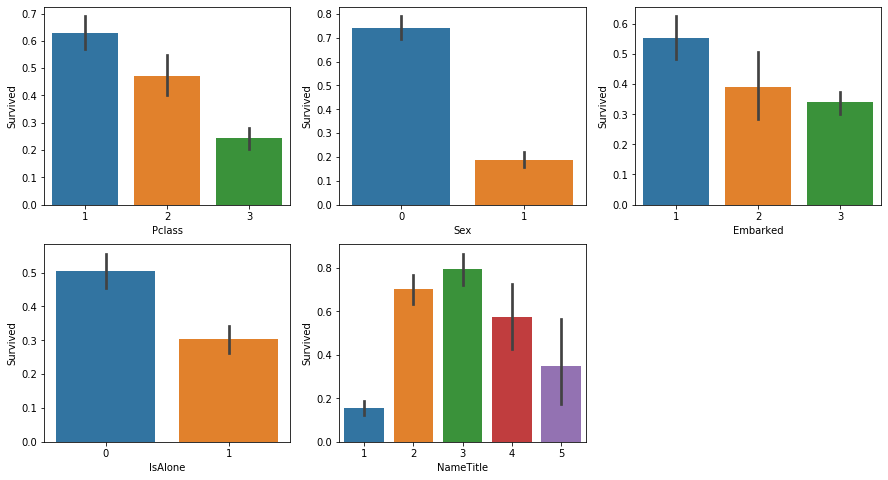

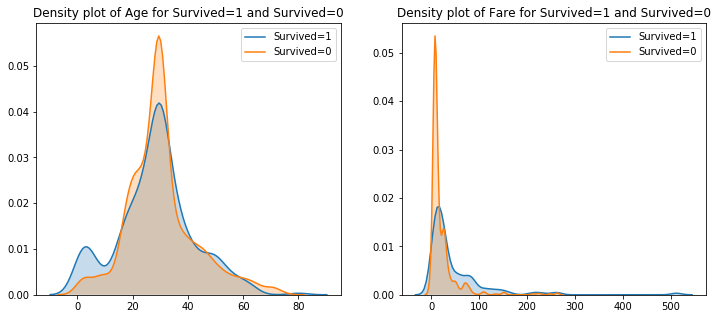

In [8]:
# 对类别型变量
plt.figure(figsize=(15,8))
class_lst = ['Pclass', 'Sex', 'Embarked', 'IsAlone', 'NameTitle']
for i, column in enumerate(class_lst):
    plt.subplot(2,3,i+1)
    sns.barplot(column, 'Survived', data=train_1)
plt.show()

# 对连续型变量
plt.figure(figsize=(12,5))
for i, column in enumerate(['Age', 'Fare']):
    plt.subplot(1,2,i+1)
    sns.kdeplot(train_1[column][train_1['Survived']==1], shade=True)
    sns.kdeplot(train_1[column][train_1['Survived']==0], shade=True)
    plt.legend(['Survived=1', 'Survived=0'])
    plt.title('Density plot of {} for Survived=1 and Survived=0'.format(column))
plt.show()

分析认为，类别型变量间对Survived都具有显著差异；而连续型变量也存在较大的差异，所以用这些特征来建立模型。

###### 5 建立模型

In [9]:
x_train, x_test, y_train, y_test = train_test_split(train_1.loc[:, train_1.columns!='Survived'], train_1['Survived'], random_state=2019)

In [10]:

rf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=6, min_samples_split=2,
                            min_samples_leaf=2, n_jobs=2, max_features='sqrt', random_state=2019)
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_test)
print("rf's accuracy is", accuracy_score(y_test, rf_pred))

et = ExtraTreesClassifier(n_estimators=100, criterion='gini', max_depth=6, min_samples_split=2,
                            min_samples_leaf=2, n_jobs=2, max_features='sqrt', random_state=2019)
et.fit(x_train, y_train)
et_pred = et.predict(x_test)
print("et's accuracy is", accuracy_score(y_test, et_pred))

gb = GradientBoostingClassifier(n_estimators=99, max_depth=6, min_samples_leaf=2, random_state=2019)
gb.fit(x_train, y_train)
gb_pred = gb.predict(x_test)
print("gb's accuracy is", accuracy_score(y_test, gb_pred))

ada = AdaBoostClassifier(n_estimators=100, learning_rate=0.75, random_state=2019)
ada.fit(x_train, y_train)
ada_pred = ada.predict(x_test)
print("ada's accuracy is", accuracy_score(y_test, ada_pred))

svc = SVC(C=0.5, kernel='rbf', random_state=2019)
svc.fit(x_train, y_train)
svc_pred = svc.predict(x_test)
print("svc's accuracy is", accuracy_score(y_test, svc_pred))
## poly核运行非常非常慢，根电脑卡了似的 ##

xgb_class = xgb.XGBClassifier(max_depth=6, learning_rate=0.01)
xgb_class.fit(x_train, y_train)
xgb_pred = xgb_class.predict(x_test)
print("xgb's accuracy is", accuracy_score(y_test, xgb_pred))

rf's accuracy is 0.8654708520179372
et's accuracy is 0.852017937219731
gb's accuracy is 0.8026905829596412
ada's accuracy is 0.8251121076233184
svc's accuracy is 0.6995515695067265
xgb's accuracy is 0.8475336322869955


In [11]:
xgb_class2 = xgb.XGBClassifier(max_depth=6, learning_rate=0.01)
stackingC = StackingClassifier(classifiers=[rf, et, gb, ada, svc], 
                               use_probas=False, average_probas=True, meta_classifier=xgb_class)
stackingC.fit(x_train, y_train)
stackingC_pred = stackingC.predict(x_test)
print("stacking's accuracy is", accuracy_score(y_test, stackingC_pred))

stacking's accuracy is 0.8026905829596412


比较发现，rf的效果是最好的，用xgb集成的模型效果不如rf。所以最终选择rf。

In [16]:
test_pred = rf.predict(test_1)

In [17]:
PassengerId = test['PassengerId']
submission = pd.DataFrame({'PassengerId': PassengerId, 'Survived':test_pred})
submission.to_csv('mySubmission.csv', index=False)